In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    average_precision_score,
    precision_recall_curve,
)
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
import warnings

## 1. Load Processed Data (feature engineering; 24h; aggregation)

In [2]:
df_agg = pd.read_csv('../../data/mimic_dataset_24h_aggregated.csv')
df_agg.head()

,gender,age,elixhauser,re_admission,Height_cm,Weight_kg,mechvent_mean,mechvent_max,extubated_mean,extubated_max,...,SOFA_min,SOFA_max,SOFA_std,SOFA_last,SIRS_mean,SIRS_min,SIRS_max,SIRS_std,SIRS_last,died_in_hosp
0,1,61,1,0,173.00,115.0,0.000000,0,0.0,0,...,13,13,NaN,13,1.000000,1,1,NaN,1,0
1,1,92,4,1,163.00,68.5,0.000000,0,0.0,0,...,2,8,2.225395,5,2.285714,1,4,0.951190,2,0
2,1,78,9,0,182.88,90.0,0.714286,1,0.0,0,...,5,8,0.975900,7,2.571429,2,3,0.534522,2,0
3,1,56,4,0,178.00,119.3,0.000000,0,0.0,0,...,8,9,0.534522,9,2.000000,0,3,1.000000,0,0
4,0,61,8,0,180.34,78.4,0.000000,0,0.0,0,...,9,11,0.707107,10,1.800000,1,2,0.447214,2,1


## 2. Define X and y

In [3]:
target_col = 'died_in_hosp'
y = df_agg[target_col].astype(int)
X = df_agg.drop(columns=[target_col])

In [5]:
print(f"class distribution:")
print(f"  died patients (1): {(y==1).sum()} ({(y==1).mean()*100:.1f}%)")
print(f"  survived patients (0): {(y==0).sum()} ({(y==0).mean()*100:.1f}%)")

class distribution:
  died patients (1): 4784 (16.5%)
  survived patients (0): 24276 (83.5%)


## 3. Data Splitting  
- Divide the dataset into the training set and the test set, with an 80/20 ratio.
- To ensure that the proportion of deceased/survived patients in the training set and the test set is consistent with the original data, `stratified sampling` is adopted.

In [4]:
test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=test_size, 
    random_state=42, 
    stratify=y
)

print(f"Size of the training set: {X_train.shape}")
print(f"Size of the testing set: {X_test.shape}")
print(f"Training set mortality rate: {y_train.mean():.3f}")
print(f"Testing set mortality rate: {y_test.mean():.3f}")

Size of the training set: (23248, 325)
Size of the testing set: (5812, 325)
Training set mortality rate: 0.165
Testing set mortality rate: 0.165


## 4. Missing Value Imputation

- For numerical features, using the median is often more robust than the mean, as it is not affected by outliers. For categorical features, the mode can be used. 
    
- The imputation values are calculated only on the training set and then applied to both the training and testing sets to prevent data leakage.

In [9]:
print(f"Proportion of missing values:")
missing_proportion = (X.isnull().sum()/X.shape[0]).sort_values(ascending=False) 
print(missing_proportion)

Proportion of missing values:
ETCO2_std          0.087027
ETCO2_mean         0.056435
ETCO2_min          0.056435
ETCO2_max          0.056435
ETCO2_last         0.056435
                     ...   
Potassium_max      0.000000
Potassium_min      0.000000
Potassium_mean     0.000000
PAWplateau_last    0.000000
SIRS_last          0.000000
Length: 325, dtype: float64


In [5]:
imputer = SimpleImputer(strategy='median')

X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

## 5. Feature Scaling    
    
Random Forest doesn't need feature scaling (tree-based models are scale-invariant)

## 6. Random Forest Training and Hyperparameter Tuning

In [ ]:
def objective(trial):
    """
    Optuna objective function for Random Forest hyperparameter optimization.
    Uses StratifiedKFold cross-validation and evaluates using AUCPR with overfitting penalty
    """
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000, step=100),
        'max_depth': trial.suggest_int('max_depth', 5, 30),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', 0.3, 0.5, 0.7]),
        'min_impurity_decrease': trial.suggest_float('min_impurity_decrease', 0.0, 0.01),  # regularization to reduce overfitting
        'max_samples': trial.suggest_float('max_samples', 0.6, 1.0),  # bootstrap sampling
        'criterion': trial.suggest_categorical('criterion', ['gini', 'entropy']),
        'class_weight': 'balanced',  # imbalanced data handling
        'bootstrap': True,
        'oob_score': True,  # Out-of-bag score
        'random_state': 42,
        'n_jobs': -1
    }
    
    # StratifiedKFold cross-validation
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    cv_scores_auc = []
    cv_scores_aucpr = []  # AUCPR is more relevant for imbalanced data
    train_scores = []  # monitor training performance for overfitting analysis
    
    for fold_idx, (train_idx, val_idx) in enumerate(cv.split(X_train_imputed, y_train)):
        X_fold_train = X_train_imputed[train_idx]
        y_fold_train = y_train.iloc[train_idx]
        X_fold_val = X_train_imputed[val_idx]
        y_fold_val = y_train.iloc[val_idx]
        
        model = RandomForestClassifier(**params)
        
        model.fit(X_fold_train, y_fold_train)
        
        y_train_proba = model.predict_proba(X_fold_train)[:, 1]
        y_val_proba = model.predict_proba(X_fold_val)[:, 1]
        
        train_auc = roc_auc_score(y_fold_train, y_train_proba)
        val_auc = roc_auc_score(y_fold_val, y_val_proba)
        val_aucpr = average_precision_score(y_fold_val, y_val_proba)  # main metric
        
        train_scores.append(train_auc)
        cv_scores_auc.append(val_auc)
        cv_scores_aucpr.append(val_aucpr)
        
        # Optuna pruning
        trial.report(val_aucpr, fold_idx)
        if trial.should_prune():
            raise optuna.TrialPruned()
    
    mean_cv_auc = np.mean(cv_scores_auc)
    mean_cv_aucpr = np.mean(cv_scores_aucpr)
    mean_train_score = np.mean(train_scores)
    
    # overfitting peanlty
    overfitting_penalty = abs(mean_train_score - mean_cv_auc)
    if overfitting_penalty > 0.05:  # threshold: 5%
        mean_cv_aucpr -= overfitting_penalty * 0.5  
    
    trial.set_user_attr('mean_train_auc', mean_train_score)
    trial.set_user_attr('mean_val_auc', mean_cv_auc)
    trial.set_user_attr('mean_val_aucpr', mean_cv_aucpr)
    trial.set_user_attr('overfitting_gap', overfitting_penalty)
    
    return mean_cv_aucpr  

In [12]:
study = optuna.create_study(
    direction='maximize',  # maximize AUCPR
    sampler=optuna.samplers.TPESampler(seed=42),  # TPE sampler
    pruner=optuna.pruners.MedianPruner(  # Median pruner
        n_startup_trials=10,
        n_warmup_steps=2,
        interval_steps=1
    )
)

study.optimize(objective, n_trials=100, show_progress_bar=True)

[I 2025-10-16 14:34:48,355] A new study created in memory with name: no-name-4be65f5a-f117-4e16-8c54-dfb640e6d578


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-10-16 14:38:35,910] Trial 0 finished with value: 0.48115830978934665 and parameters: {'n_estimators': 400, 'max_depth': 29, 'min_samples_split': 15, 'min_samples_leaf': 6, 'max_features': 0.5, 'min_impurity_decrease': 0.007080725777960455, 'max_samples': 0.608233797718321, 'criterion': 'gini'}. Best is trial 0 with value: 0.48115830978934665.
[I 2025-10-16 14:46:07,895] Trial 1 finished with value: 0.5406220384261553 and parameters: {'n_estimators': 300, 'max_depth': 9, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 0.5, 'min_impurity_decrease': 0.0029214464853521815, 'max_samples': 0.7465447373174767, 'criterion': 'entropy'}. Best is trial 1 with value: 0.5406220384261553.
[I 2025-10-16 14:50:27,587] Trial 2 finished with value: 0.4986506985260216 and parameters: {'n_estimators': 200, 'max_depth': 18, 'min_samples_split': 13, 'min_samples_leaf': 1, 'max_features': 0.7, 'min_impurity_decrease': 0.008083973481164611, 'max_samples': 0.7218455076693483, 'criterion'

In [19]:
best_params = study.best_params
best_score = study.best_value

print(f"best cross-validated AUCPR: {best_score:.4f}")
print(f"best parameters:")
for param, value in sorted(best_params.items()):
    print(f"  {param}: {value}")

best_trial = study.best_trial
print(f"\nbest trial details:")
print(f"  training set average AUC: {best_trial.user_attrs['mean_train_auc']:.4f}")
print(f"  test set average AUC: {best_trial.user_attrs['mean_val_auc']:.4f}")
print(f"  test set average AUCPR: {best_trial.user_attrs['mean_val_aucpr']:.4f}")
print(f"  Overfitting gap: {best_trial.user_attrs['overfitting_gap']:.4f}")


best cross-validated AUCPR: 0.5497
best parameters:
  criterion: entropy
  max_depth: 6
  max_features: 0.3
  max_samples: 0.7063976854922233
  min_impurity_decrease: 0.0016463879773134444
  min_samples_leaf: 2
  min_samples_split: 5
  n_estimators: 400

best trial details:
  training set average AUC: 0.8689
  test set average AUC: 0.8293
  test set average AUCPR: 0.5497
  Overfitting gap: 0.0396


In [ ]:
best_rf = RandomForestClassifier(
    class_weight='balanced',
    bootstrap=True,
    oob_score=True,
    random_state=42,
    n_jobs=-1,
    **best_params
)

best_rf.fit(X_train_imputed, y_train)

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=6, max_features=0.3,
                       max_samples=0.7063976854922233,
                       min_impurity_decrease=0.0016463879773134444,
                       min_samples_leaf=2, min_samples_split=5,
                       n_estimators=400, n_jobs=-1, oob_score=True,
                       random_state=42)

## 7. Model Evaluation

In [7]:
y_train_pred = best_rf.predict(X_train_imputed)
y_test_pred = best_rf.predict(X_test_imputed)
y_train_proba = best_rf.predict_proba(X_train_imputed)[:, 1]
y_test_proba = best_rf.predict_proba(X_test_imputed)[:, 1]

# Training set performance
print("Training set performance:")
train_auc = roc_auc_score(y_train, y_train_proba)
train_acc = best_rf.score(X_train_imputed, y_train)
print(f"  Accuracy: {train_acc:.4f}")
print(f"  AUC-ROC: {train_auc:.4f}")
print(f"  AUPRC: {average_precision_score(y_train, y_train_proba):.4f}")
print(classification_report(y_train, y_train_pred))

# Test set performance
print("\nTest set performance:")
test_auc = roc_auc_score(y_test, y_test_proba)
test_acc = best_rf.score(X_test_imputed, y_test)
print(f"  Accuracy: {test_acc:.4f}")
print(f"  AUC-ROC: {test_auc:.4f}")
print(f"  AUPRC: {average_precision_score(y_test, y_test_proba):.4f}")
print(classification_report(y_test, y_test_pred))


Training set performance:
  Accuracy: 0.8026
  AUC-ROC: 0.8583
  AUPRC: 0.5989
              precision    recall  f1-score   support

           0       0.94      0.82      0.87     19421
           1       0.44      0.73      0.55      3827

    accuracy                           0.80     23248
   macro avg       0.69      0.77      0.71     23248
weighted avg       0.86      0.80      0.82     23248


Test set performance:
  Accuracy: 0.7944
  AUC-ROC: 0.8420
  AUPRC: 0.5749
              precision    recall  f1-score   support

           0       0.93      0.81      0.87      4855
           1       0.42      0.69      0.53       957

    accuracy                           0.79      5812
   macro avg       0.68      0.75      0.70      5812
weighted avg       0.85      0.79      0.81      5812



In [13]:
# Overfitting check
print(f"\nOverfitting analysis:")
print(f"  Train-Test AUC difference: {(train_auc - test_auc):.4f}")
if train_auc - test_auc < 0.05:
    print(f"Low overfitting (difference < 0.05)")
elif train_auc - test_auc < 0.10:
    print(f"Mild overfitting (difference 0.05-0.10)")
else:
    print(f"Significant overfitting (difference > 0.10)")

# Confusion matrix
print("\nConfusion Matrix (Test Set):")
cm = confusion_matrix(y_test, y_test_pred)
print(f"  True Negative (TN): {cm[0,0]}, False Positive (FP): {cm[0,1]}")
print(f"  False Negative (FN): {cm[1,0]}, True Positive (TP): {cm[1,1]}")

# Calculate additional metrics
sensitivity = cm[1,1] / (cm[1,1] + cm[1,0])  # Recall/Sensitivity
specificity = cm[0,0] / (cm[0,0] + cm[0,1])  # Specificity
precision = cm[1,1] / (cm[1,1] + cm[0,1])    # Precision
npv = cm[0,0] / (cm[0,0] + cm[1,0])          # Negative Predictive Value

print(f"\nDetailed Performance Metrics:")
print(f"  Sensitivity (Recall): {sensitivity:.3f}")
print(f"  Specificity: {specificity:.3f}")
print(f"  Precision: {precision:.3f}")
print(f"  Negative Predictive Value (NPV): {npv:.3f}")



Overfitting analysis:
  Train-Test AUC difference: 0.0163
Low overfitting (difference < 0.05)

Confusion Matrix (Test Set):
  True Negative (TN): 3954, False Positive (FP): 901
  False Negative (FN): 294, True Positive (TP): 663

Detailed Performance Metrics:
  Sensitivity (Recall): 0.693
  Specificity: 0.814
  Precision: 0.424
  Negative Predictive Value (NPV): 0.931


## 8. Feature Importance Analysis

In [15]:
# Random Forest feature importance (based on mean impurity decrease)
feature_names = X.columns.tolist()
feature_importance = best_rf.feature_importances_

importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importance
}).sort_values('importance', ascending=False)

print(f"\nTop 20 Most Important Features:")
for i, row in importance_df.head(20).iterrows():
    print(f"{row['feature']:30s}: {row['importance']:.6f}")

# Cumulative importance analysis
importance_df['cumulative_importance'] = importance_df['importance'].cumsum()
n_features_90 = (importance_df['cumulative_importance'] <= 0.90).sum()
n_features_95 = (importance_df['cumulative_importance'] <= 0.95).sum()

print(f"\nCumulative Feature Importance Analysis:")
print(f"  Top {n_features_90} features contribute 90% of importance")
print(f"  Top {n_features_95} features contribute 95% of importance")
print(f"  Total number of features: {len(feature_names)}")


Top 20 Most Important Features:
SOFA_mean                     : 0.086694
GCS_last                      : 0.078447
RASS_last                     : 0.071314
SOFA_last                     : 0.065201
output_step_mean              : 0.048056
median_dose_vaso_last         : 0.036203
FiO2_100_last                 : 0.033531
FiO2_1_last                   : 0.032139
output_step_max               : 0.029209
max_dose_vaso_last            : 0.024467
elixhauser                    : 0.023491
BUN_last                      : 0.022910
SOFA_min                      : 0.022198
Arterial_lactate_last         : 0.018552
age                           : 0.017943
RASS_mean                     : 0.015146
output_total_std              : 0.014962
Arterial_lactate_mean         : 0.014878
GCS_mean                      : 0.014513
SIRS_mean                     : 0.013032

Cumulative Feature Importance Analysis:
  Top 67 features contribute 90% of importance
  Top 122 features contribute 95% of importance
  Total num

## 9. Visualization

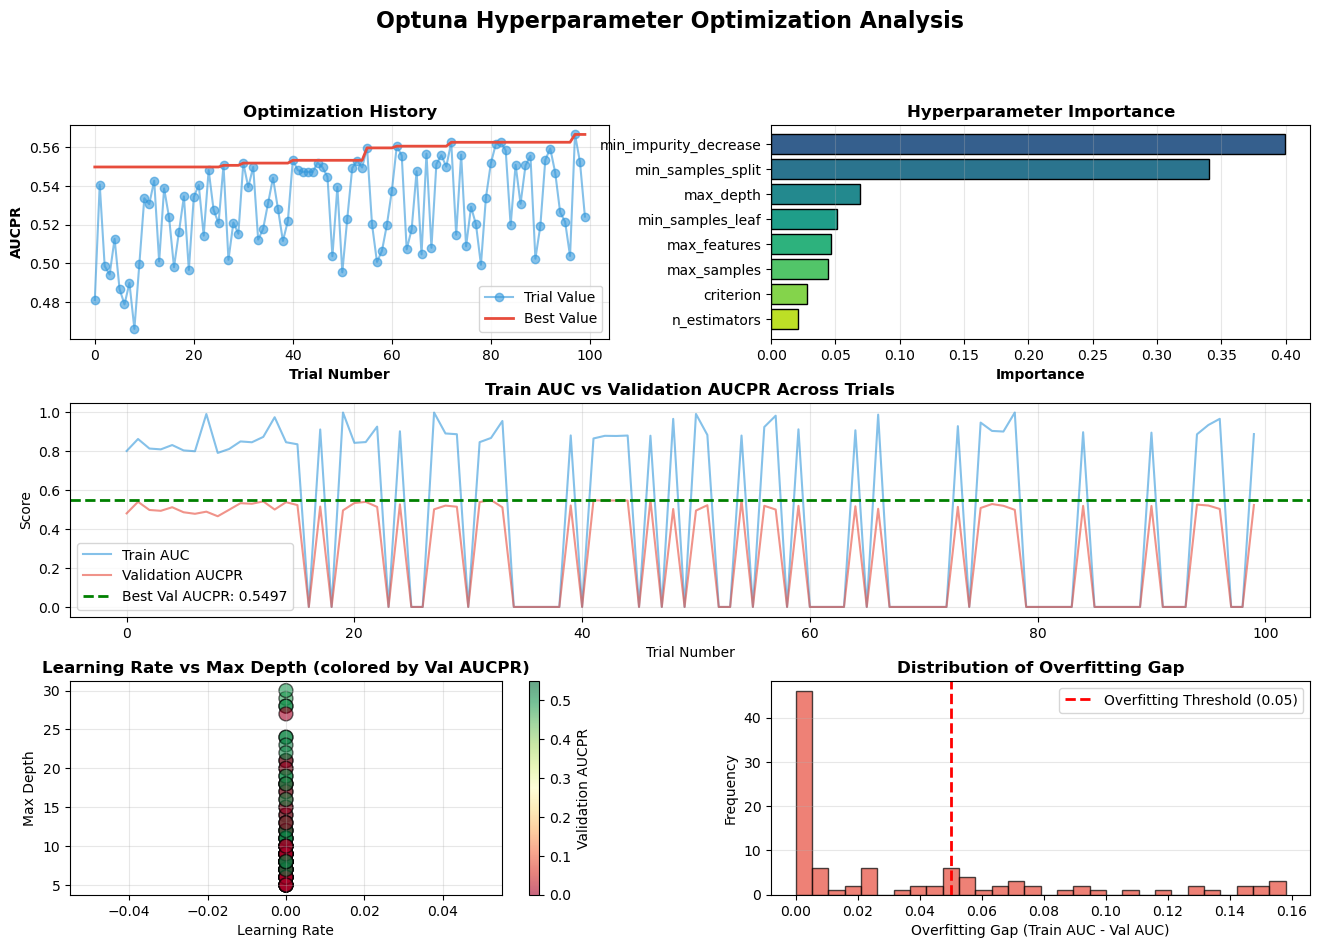

In [ ]:
fig_optuna = plt.figure(figsize=(16, 10))
gs_optuna = fig_optuna.add_gridspec(3, 2, hspace=0.3, wspace=0.3)

# 1. optimization history
ax1 = fig_optuna.add_subplot(gs_optuna[0, 0])
trial_numbers = [trial.number for trial in study.trials]
trial_values = [trial.value if trial.value is not None else 0 for trial in study.trials]
best_values = [study.best_value if i == 0 else max(study.best_value, max(trial_values[:i+1])) 
               for i in range(len(trial_values))]

ax1.plot(trial_numbers, trial_values, marker='o', alpha=0.6, label='Trial Value', color='#3498db')
ax1.plot(trial_numbers, best_values, linewidth=2, label='Best Value', color='#e74c3c')
ax1.set_xlabel('Trial Number', fontweight='bold')
ax1.set_ylabel('AUCPR', fontweight='bold')
ax1.set_title('Optimization History', fontsize=12, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. parameter importance
ax2 = fig_optuna.add_subplot(gs_optuna[0, 1])
try:
    importances = optuna.importance.get_param_importances(study)
    param_names = list(importances.keys())
    importance_values = list(importances.values())
    
    top_n = min(8, len(param_names))
    param_names = param_names[:top_n]
    importance_values = importance_values[:top_n]
    
    colors = plt.cm.viridis(np.linspace(0.3, 0.9, len(param_names)))
    ax2.barh(range(len(param_names)), importance_values, color=colors, edgecolor='black')
    ax2.set_yticks(range(len(param_names)))
    ax2.set_yticklabels(param_names)
    ax2.set_xlabel('Importance', fontweight='bold')
    ax2.set_title('Hyperparameter Importance', fontsize=12, fontweight='bold')
    ax2.invert_yaxis()
    ax2.grid(True, axis='x', alpha=0.3)
except:
    ax2.text(0.5, 0.5, 'Not enough trials for importance analysis', 
             ha='center', va='center', transform=ax2.transAxes, fontsize=12)

# 3. overfitting analysis(AUCPR)
ax3 = fig_optuna.add_subplot(gs_optuna[1, :])
train_aucs = [trial.user_attrs.get('mean_train_auc', 0) for trial in study.trials]
val_aucprs = [trial.user_attrs.get('mean_val_aucpr', 0) for trial in study.trials]
trial_numbers = range(len(study.trials))

ax3.plot(trial_numbers, train_aucs, label='Train AUC', alpha=0.6, color='#3498db')
ax3.plot(trial_numbers, val_aucprs, label='Validation AUCPR', alpha=0.6, color='#e74c3c')
ax3.axhline(y=best_score, color='green', linestyle='--', 
            label=f'Best Val AUCPR: {best_score:.4f}', linewidth=2)
ax3.set_xlabel('Trial Number')
ax3.set_ylabel('Score')
ax3.set_title('Train AUC vs Validation AUCPR Across Trials', fontsize=12, fontweight='bold')
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. Learning Rate vs Max Depth scatter plot
ax4 = fig_optuna.add_subplot(gs_optuna[2, 0])
lr_values = [trial.params.get('learning_rate', 0) for trial in study.trials]
depth_values = [trial.params.get('max_depth', 0) for trial in study.trials]
val_aucprs_scatter = [trial.user_attrs.get('mean_val_aucpr', 0) for trial in study.trials]
scatter = ax4.scatter(lr_values, depth_values, c=val_aucprs_scatter, 
                     cmap='RdYlGn', s=100, alpha=0.6, edgecolors='black')
ax4.set_xlabel('Learning Rate')
ax4.set_ylabel('Max Depth')
ax4.set_title('Learning Rate vs Max Depth (colored by Val AUCPR)', 
              fontsize=12, fontweight='bold')
plt.colorbar(scatter, ax=ax4, label='Validation AUCPR')
ax4.grid(True, alpha=0.3)

# 5. Overfitting gap distribution
ax5 = fig_optuna.add_subplot(gs_optuna[2, 1])
overfitting_gaps = [trial.user_attrs.get('overfitting_gap', 0) for trial in study.trials]
ax5.hist(overfitting_gaps, bins=30, color='#e74c3c', alpha=0.7, edgecolor='black')
ax5.axvline(x=0.05, color='red', linestyle='--', 
            label='Overfitting Threshold (0.05)', linewidth=2)
ax5.set_xlabel('Overfitting Gap (Train AUC - Val AUC)')
ax5.set_ylabel('Frequency')
ax5.set_title('Distribution of Overfitting Gap', fontsize=12, fontweight='bold')
ax5.legend()
ax5.grid(True, alpha=0.3, axis='y')

plt.suptitle('Optuna Hyperparameter Optimization Analysis', 
             fontsize=16, fontweight='bold', y=0.995)
plt.show()

Text(67, 0.5, 'n=67')

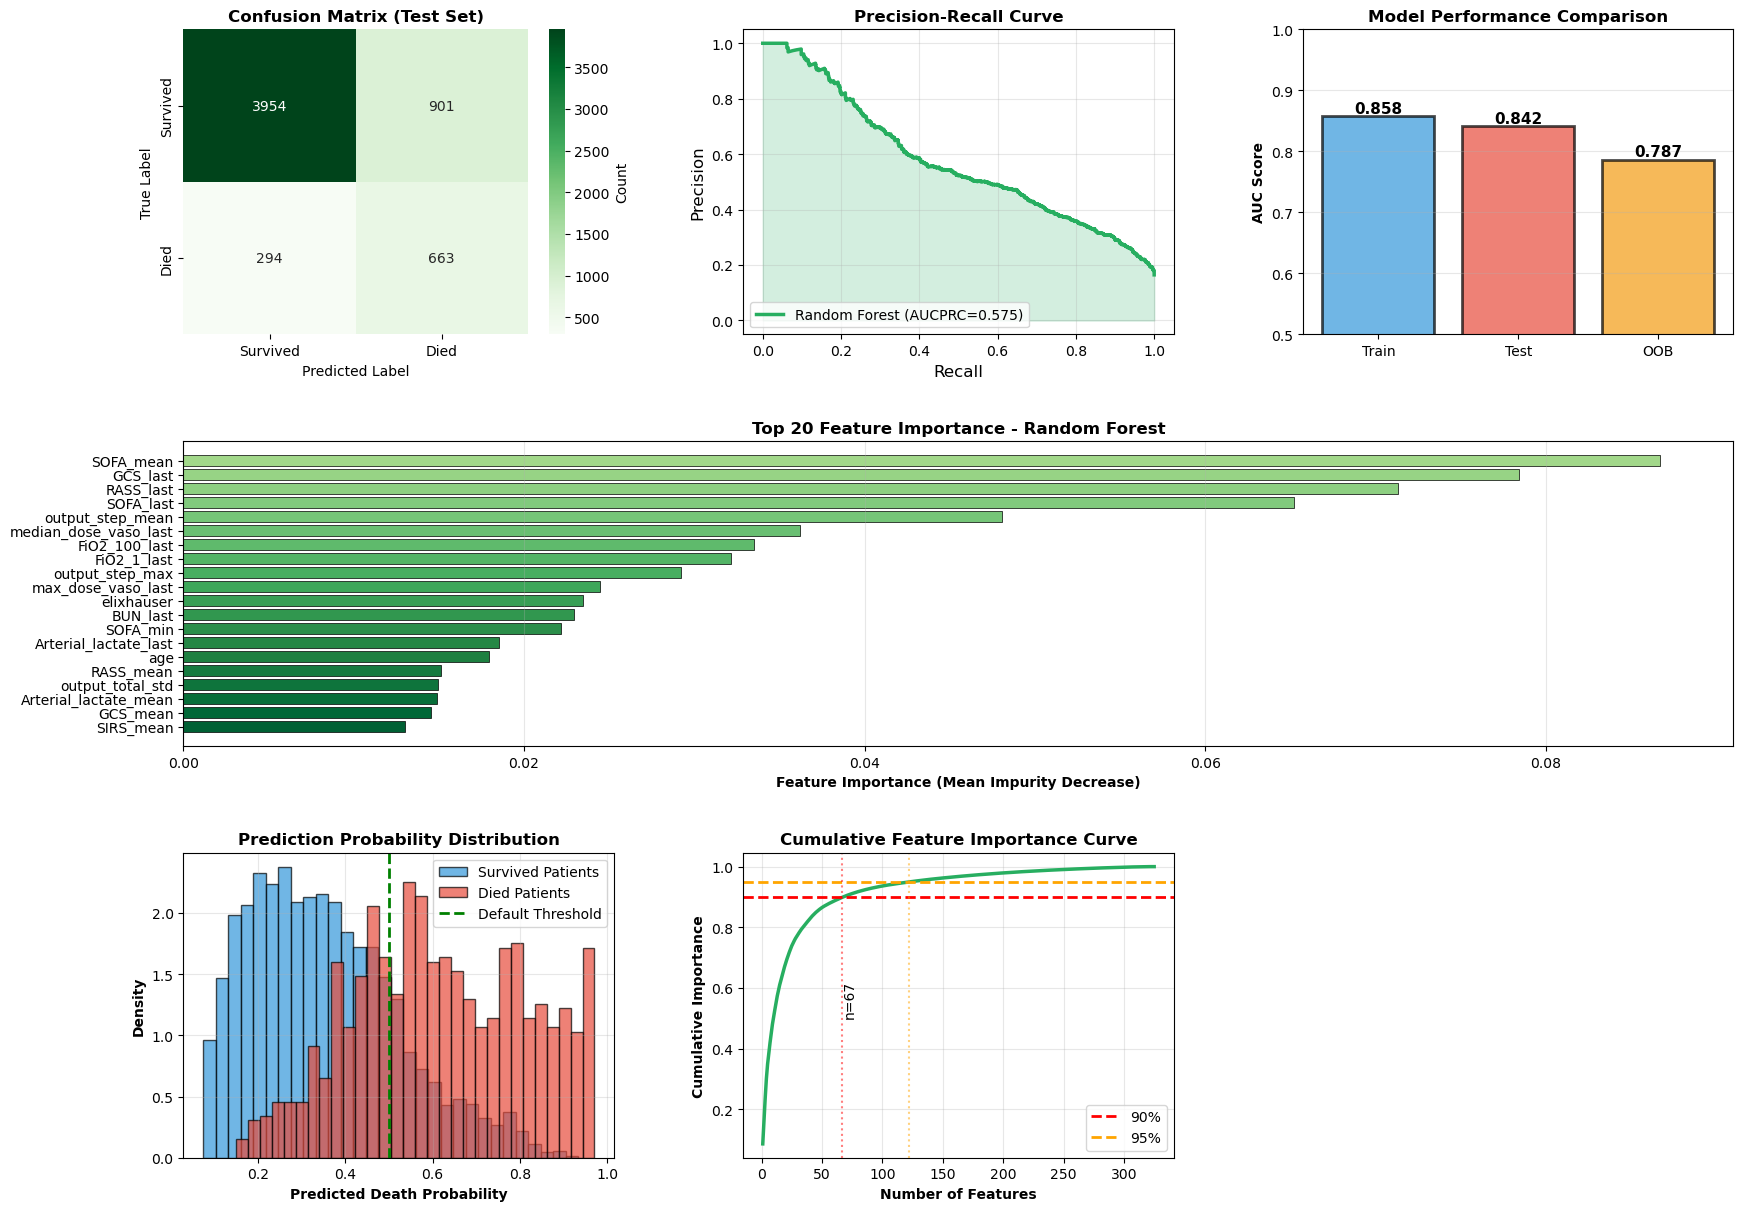

In [ ]:
fig = plt.figure(figsize=(20, 20))
gs = fig.add_gridspec(4, 3, hspace=0.35, wspace=0.3)

# 1. Confusion Matrix
ax1 = fig.add_subplot(gs[0, 0])
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', ax=ax1,
            xticklabels=['Survived', 'Died'], 
            yticklabels=['Survived', 'Died'],
            cbar_kws={'label': 'Count'})
ax1.set_title('Confusion Matrix (Test Set)', fontsize=12, fontweight='bold')
ax1.set_xlabel('Predicted Label')
ax1.set_ylabel('True Label')

# 2. Precision-Recall Curve
ax2 = fig.add_subplot(gs[0, 1])
precision, recall, thresholds = precision_recall_curve(y_test, y_test_proba)
aucprc = average_precision_score(y_test, y_test_proba)

ax2.plot(recall, precision, label=f'Random Forest (AUCPRC={aucprc:.3f})', 
         linewidth=2.5, color='#27ae60')
ax2.fill_between(recall, precision, alpha=0.2, color='#27ae60')
ax2.set_xlabel('Recall', fontsize=12)
ax2.set_ylabel('Precision', fontsize=12)
ax2.set_title('Precision-Recall Curve', fontsize=12, fontweight='bold')
ax2.legend(loc='lower left', fontsize=10)
ax2.grid(True, alpha=0.3)

# 3. Train vs Test vs OOB Comparison
ax3 = fig.add_subplot(gs[0, 2])
scores = [train_auc, test_auc, best_rf.oob_score_]
labels = ['Train', 'Test', 'OOB']
colors = ['#3498db', '#e74c3c', '#f39c12']
bars = ax3.bar(labels, scores, color=colors, alpha=0.7, edgecolor='black', linewidth=2)
ax3.set_ylabel('AUC Score', fontweight='bold')
ax3.set_title('Model Performance Comparison', fontsize=12, fontweight='bold')
ax3.set_ylim([0.5, 1.0])
for bar, score in zip(bars, scores):
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height,
             f'{score:.3f}', ha='center', va='bottom', 
             fontweight='bold', fontsize=11)
ax3.grid(True, alpha=0.3, axis='y')

# 4. Top 20 Feature Importance
ax4 = fig.add_subplot(gs[1, :])
top20 = importance_df.head(20)
colors_feat = plt.cm.YlGn(np.linspace(0.4, 0.9, len(top20)))
bars = ax4.barh(range(len(top20)), top20['importance'], color=colors_feat, 
                edgecolor='black', linewidth=0.5)
ax4.set_yticks(range(len(top20)))
ax4.set_yticklabels(top20['feature'])
ax4.set_xlabel('Feature Importance (Mean Impurity Decrease)', fontweight='bold')
ax4.set_title('Top 20 Feature Importance - Random Forest', 
              fontsize=12, fontweight='bold')
ax4.invert_yaxis()
ax4.grid(True, axis='x', alpha=0.3)

# 5. Prediction Probability Distribution
ax5 = fig.add_subplot(gs[2, 0])
ax5.hist(y_test_proba[y_test==0], bins=30, alpha=0.7, 
         label='Survived Patients', density=True, color='#3498db', edgecolor='black')
ax5.hist(y_test_proba[y_test==1], bins=30, alpha=0.7, 
         label='Died Patients', density=True, color='#e74c3c', edgecolor='black')
ax5.axvline(x=0.5, color='green', linestyle='--', linewidth=2, label='Default Threshold')
ax5.set_xlabel('Predicted Death Probability', fontweight='bold')
ax5.set_ylabel('Density', fontweight='bold')
ax5.set_title('Prediction Probability Distribution', fontsize=12, fontweight='bold')
ax5.legend()
ax5.grid(True, alpha=0.3)

# 6. Cumulative Feature Importance
ax6 = fig.add_subplot(gs[2, 1])
ax6.plot(range(1, len(importance_df)+1), 
         importance_df['cumulative_importance'].values,
         linewidth=2.5, color='#27ae60')
ax6.axhline(y=0.90, color='red', linestyle='--', linewidth=2, label='90%')
ax6.axhline(y=0.95, color='orange', linestyle='--', linewidth=2, label='95%')
ax6.axvline(x=n_features_90, color='red', linestyle=':', alpha=0.5)
ax6.axvline(x=n_features_95, color='orange', linestyle=':', alpha=0.5)
ax6.set_xlabel('Number of Features', fontweight='bold')
ax6.set_ylabel('Cumulative Importance', fontweight='bold')
ax6.set_title('Cumulative Feature Importance Curve', fontsize=12, fontweight='bold')
ax6.legend()
ax6.grid(True, alpha=0.3)
ax6.text(n_features_90, 0.5, f'n={n_features_90}', rotation=90, va='bottom')
